In [1]:
import torch
import torchnmf
from torchaudio import load
import numpy as np
import matplotlib.pyplot as plt

from torchnmf.nmf import NMF as torchNMF
from sklearn.decomposition import NMF as skNMF
from scipy.sparse import coo_matrix
from time import time

import os

torch.set_flush_denormal(True)

torchnmf.__version__

'0.3.4'

In [2]:
!lscpu | grep "CPU"
print(torch.cuda.get_device_name())

CPU op-mode(s):                  32-bit, 64-bit
CPU(s):                          8
On-line CPU(s) list:             0-7
CPU family:                      6
Model name:                      Intel(R) Core(TM) i7-4790K CPU @ 4.00GHz
CPU MHz:                         4317.602
CPU max MHz:                     4400.0000
CPU min MHz:                     800.0000
NUMA node0 CPU(s):               0-7
Vulnerability Mds:               Mitigation; Clear CPU buffers; SMT vulnerable
GeForce RTX 3070


# Dense Target

In [3]:
duration = 60
y, sr = load(os.path.expanduser('~/Datasets/MAPS/MAPS_MUS-alb_se2_ENSTDkCl.wav'), normalize=True)
y = y.mean(0)[:duration * sr]
windowsize = 2048
S = torch.stft(y, windowsize, window=torch.hann_window(windowsize), return_complex=True).abs() #+ 1e-8#.pow(2)
print(S.size())

torch.Size([1025, 5168])


beta = 0
Epoch 10 reached after 3.001 seconds, error: 1690.027810
Epoch 20 reached after 5.869 seconds, error: 1573.757129
Epoch 30 reached after 8.700 seconds, error: 1524.768999
Epoch 40 reached after 11.570 seconds, error: 1497.836273
Epoch 50 reached after 14.422 seconds, error: 1480.737485
Epoch 60 reached after 17.319 seconds, error: 1469.037865
sklearn 0.2972404917081197
/home/ycy/miniconda3/envs/torch170/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 60 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
100%|██████████| 60/60 [00:00<00:00, 525.01it/s, loss=1.35e+3]
torch 0.20807228485743204
torch + cuda 0.0019581158955891925
beta = 0.5
Epoch 10 reached after 4.616 seconds, error: 554.187919
Epoch 20 reached after 9.087 seconds, error: 498.346265
Epoch 30 reached after 13.531 seconds, error: 476.945752
Epoch 40 reached after 18.003 seconds, error: 466.099238
Epoc

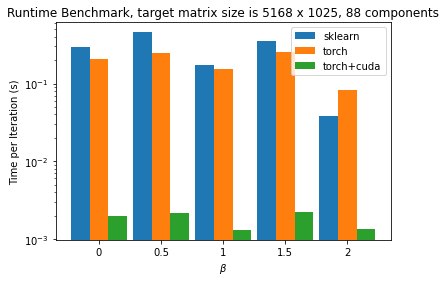

In [7]:
R = 88
max_iter = 60
tol = 1e-4

betas = [0, 0.5, 1, 1.5, 2]
sk = []
tch = []
tchcuda = []

Snumpy = S.numpy()
S = S.t()
Scuda = S.cuda()

net = torchNMF(S.shape, rank=R)

init_weights = net.state_dict()

for b in betas:
    print('beta =', b)
    model = skNMF(R, solver='mu', max_iter=max_iter, beta_loss=b, tol=tol, verbose=True)
    start = time()
    model.fit(Snumpy)
    rate = (time() - start) / model.n_iter_
    print('sklearn', rate)
    sk.append(rate)

    net.cpu()
    net.load_state_dict(init_weights)
    start = time()
    niter = net.fit(S, max_iter=max_iter, beta=b, tol=tol, verbose=True)
    rate = (time() - start) / niter
    print('torch', rate)
    tch.append(rate)

    net.load_state_dict(init_weights)
    net.cuda()
    start = time()
    niter = net.fit(Scuda, max_iter=max_iter, beta=b, tol=tol, verbose=True)
    rate = (time() - start) / niter
    print('torch + cuda', rate)
    tchcuda.append(rate)

plt.bar(np.array(betas) - 0.15, sk, width=0.15, align='center', label='sklearn')
plt.bar(betas, tch, width=0.15, align='center', label='torch')
plt.bar(np.array(betas) + 0.15, tchcuda, width=0.15, align='center', label='torch+cuda')
plt.xlabel(r'$\beta$')
plt.ylabel("Time per Iteration (s)")
plt.yscale('log')
plt.legend()
plt.title('Runtime Benchmark, target matrix size is %d x %d, %d components' % (S.shape[1], S.shape[0], R))
plt.xticks(betas, [str(i) for i in betas])
plt.show()

# Sparse Target

In [8]:
thresh = S.quantile(0.98)
indices = torch.nonzero(S > thresh).T
S_sparse = torch.sparse_coo_tensor(
    indices, S[indices[0], indices[1]], S.shape)
S_sparse_cuda = torch.sparse_coo_tensor(
    indices.cuda(), Scuda[indices[0], indices[1]], S.shape)

ii, jj = indices.numpy()
S_sparse_np = coo_matrix((Snumpy[jj, ii], (jj, ii)), shape=Snumpy.shape)
print(S_sparse_np.shape, S_sparse.shape)

(5168, 1025) torch.Size([1025, 5168])


beta = 0.5
Epoch 10 reached after 5.142 seconds, error: 621.241851
Epoch 20 reached after 10.140 seconds, error: 575.699831
Epoch 30 reached after 15.245 seconds, error: 566.866571
Epoch 40 reached after 20.321 seconds, error: 563.838571
Epoch 50 reached after 25.369 seconds, error: 562.383004
Epoch 60 reached after 30.501 seconds, error: 561.463353
sklearn 0.5123144547144572
100%|██████████| 60/60 [00:37<00:00,  1.58it/s, loss=346]
torch + cuda 0.6342665632565816
beta = 1
Epoch 10 reached after 0.718 seconds, error: 485.051730
Epoch 20 reached after 1.406 seconds, error: 444.984030
Epoch 30 reached after 2.114 seconds, error: 427.586581
Epoch 40 reached after 2.841 seconds, error: 417.624842
Epoch 50 reached after 3.522 seconds, error: 411.567505
  0%|          | 0/60 [00:00<?, ?it/s]Epoch 60 reached after 4.201 seconds, error: 407.900809
sklearn 0.07286730607350668
100%|██████████| 60/60 [00:05<00:00, 11.82it/s, loss=217]
torch + cuda 0.08481401602427165
beta = 1.5
Epoch 10 reached a

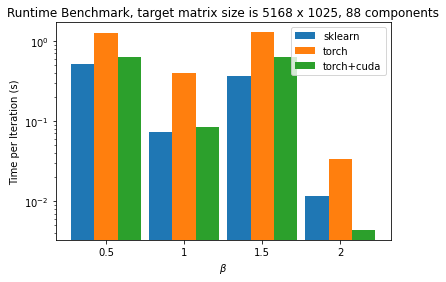

In [9]:
betas = [0.5, 1, 1.5, 2]
sk = []
tch = []
tchcuda = []

for b in betas:
    print('beta =', b)
    model = skNMF(R, solver='mu', max_iter=max_iter, beta_loss=b, tol=tol, verbose=True)
    start = time()
    model.fit(S_sparse_np)
    rate = (time() - start) / model.n_iter_
    print('sklearn', rate)
    sk.append(rate)

    net.cpu()
    net.load_state_dict(init_weights)
    start = time()
    niter = net.fit(S_sparse, max_iter=max_iter, beta=b, tol=tol, verbose=True)
    rate = (time() - start) / niter
    print('torch', rate)
    tch.append(rate)

    net.load_state_dict(init_weights)
    net.cuda()
    start = time()
    niter = net.fit(S_sparse_cuda, max_iter=max_iter, beta=b, tol=tol, verbose=True)
    rate = (time() - start) / niter
    print('torch + cuda', rate)
    tchcuda.append(rate)

plt.bar(np.array(betas) - 0.15, sk, width=0.15, align='center', label='sklearn')
plt.bar(betas, tch, width=0.15, align='center', label='torch')
plt.bar(np.array(betas) + 0.15, tchcuda, width=0.15, align='center', label='torch+cuda')
plt.xlabel(r'$\beta$')
plt.ylabel("Time per Iteration (s)")
plt.yscale('log')
plt.legend()
plt.title('Runtime Benchmark, target matrix size is %d x %d, %d components' % (S.shape[1], S.shape[0], R))
plt.xticks(betas, [str(i) for i in betas])
plt.show()